# 1. Slippage vs TVL Relationship Analysis

Analysis of the ETH/MORPHO UniV4 pool on Ethereum.

**Pool Parameters:**
- Fee: 0.2999%
- Tick spacing: 60
- Hook: address(0)
- [View on Uniswap](https://app.uniswap.org/explore/pools/ethereum/0xd9f5cbaeb88b7f0d9b0549257ddd4c46f984e2fc4bccf056cc254b9fe3417fff)

**Objectives:**
1. Calculate slippage for $5,000, $10,000, $50,000, and $100,000 trades and explain why the relationship isn't linear
2. Pull current TVL in both tokens from the V4 singleton
3. Analyze the theoretical relationship between slippage and TVL

*Hint: The UniV4 Quoter contract will make your life easier*

In [15]:
import os
import sys
from web3 import Web3
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import requests

# Add parent directory to path for imports
sys.path.append("..")

# Centralized configuration
from src.config import (
    STATE_VIEW,
    QUOTER,
    ETH,
    MORPHO,
    POOL_ID_BYTES,
    POOL_ID,
    FEE,
    TICK_SPACING,
    HOOKS,
)

# ABIs
from src.abis import (
    STATEVIEW_ABI,
    STATEVIEW_ABI_EXTENDED,
    QUOTER_ABI,
)

# Slippage calculation
from src.slippage import calculate_slippage

# TVL calculation
from src.tvl import (
    get_slot0,
    get_pool_liquidity,
    calculate_tvl_from_ticks,
    fetch_pool_tvl_graphql,
)

# Liquidity distribution utilities
from src.liquidity_distribution import find_initialized_ticks

# AMM math utilities (Decimal-based for precision)
from src.amm_math import sqrt_price_x96_to_price

In [16]:
#connecting to rcp
load_dotenv()
url = os.getenv('rpc_url_mainnet')
w3 = Web3(Web3.HTTPProvider(url))

if not w3:
    raise Exception('Could not connect to Alchemy')
else:
    print('Connected to Alchemy')

Connected to Alchemy


## Setup

**Contract Addresses:**
- Pool Manager (V4 Singleton)
- Quoter (off-chain swap simulation)
- StateView (read-only helper)

**ABIs:**
- Get prices and fees
- Simulate swaps

In [17]:
# Convert addresses to checksum format for Web3
QUOTER_CS = Web3.to_checksum_address(QUOTER)
STATE_VIEW_CS = Web3.to_checksum_address(STATE_VIEW)
ETH_CS = Web3.to_checksum_address(ETH)
MORPHO_CS = Web3.to_checksum_address(MORPHO)
HOOKS_CS = Web3.to_checksum_address(HOOKS)

print(f"Pool ID: {POOL_ID}")
print(f"State View: {STATE_VIEW_CS}")
print(f"Quoter: {QUOTER_CS}")

Pool ID: 0xd9f5cbaeb88b7f0d9b0549257ddd4c46f984e2fc4bccf056cc254b9fe3417fff
State View: 0x7fFE42C4a5DEeA5b0feC41C94C136Cf115597227
Quoter: 0x52F0E24D1c21C8A0cB1e5a5dD6198556BD9E1203


## 1.1 Calculate Slippage

Trading ETH for MORPHO (zeroForOne = true).

In [18]:
# Fetch current token prices from CoinGecko
eth_resp = requests.get("https://api.coingecko.com/api/v3/simple/price?ids=ethereum&vs_currencies=usd")
eth_price_usd = eth_resp.json().get("ethereum", {}).get("usd", 0)

morpho_resp = requests.get("https://api.coingecko.com/api/v3/simple/price?ids=morpho&vs_currencies=usd")
morpho_price_usd = morpho_resp.json().get("morpho", {}).get("usd", 0)

print(f"Current ETH price:    ${eth_price_usd:,.2f}")
print(f"Current MORPHO price: ${morpho_price_usd:,.4f}")

Current ETH price:    $3,067.67
Current MORPHO price: $1.2100


In [19]:
# Calculate slippage for different trade sizes

trade_amounts_usd = [5000, 10000, 50000, 100000]
results = []

for usd_amount in trade_amounts_usd:
    # Convert USD to ETH (in wei)
    eth_amount = usd_amount / eth_price_usd
    print(f'ETH amount of {usd_amount}USD is: {eth_amount}')
    amount_in_wei = int(eth_amount * 10**18)
    
    result = calculate_slippage(
        w3=w3,
        amount_in_wei=amount_in_wei,
        stateview_address=STATE_VIEW_CS,
        stateview_abi=STATEVIEW_ABI,
        quoter_address=QUOTER_CS,
        quoter_abi=QUOTER_ABI,
        pool_id=POOL_ID_BYTES,
        currency0=ETH_CS,
        currency1=MORPHO_CS,
        fee=FEE,
        tick_spacing=TICK_SPACING,
        hooks=HOOKS_CS,
        zero_for_one=True
    )
    result["usd_amount"] = usd_amount
    result["eth_amount"] = eth_amount
    results.append(result)

# Display results
print("\n--------- SLIPPAGE RESULTS ---------")
print(f"{'USD Amount':<12} {'ETH Amount':<12} {'Slippage %':<12}")
print("-" * 36)
for r in results:
    usd_str = f"${r['usd_amount']:,}"
    print(f"{usd_str:<12} {r['eth_amount']:<12.4f} {r['slippage_percentage']:.6f}%")

ETH amount of 5000USD is: 1.62990152135008
ETH amount of 10000USD is: 3.25980304270016
ETH amount of 50000USD is: 16.299015213500798
ETH amount of 100000USD is: 32.598030427001596

--------- SLIPPAGE RESULTS ---------
USD Amount   ETH Amount   Slippage %  
------------------------------------
$5,000       1.6299       0.492068%
$10,000      3.2598       0.683496%
$50,000      16.2990      1.986270%
$100,000     32.5980      2.797699%


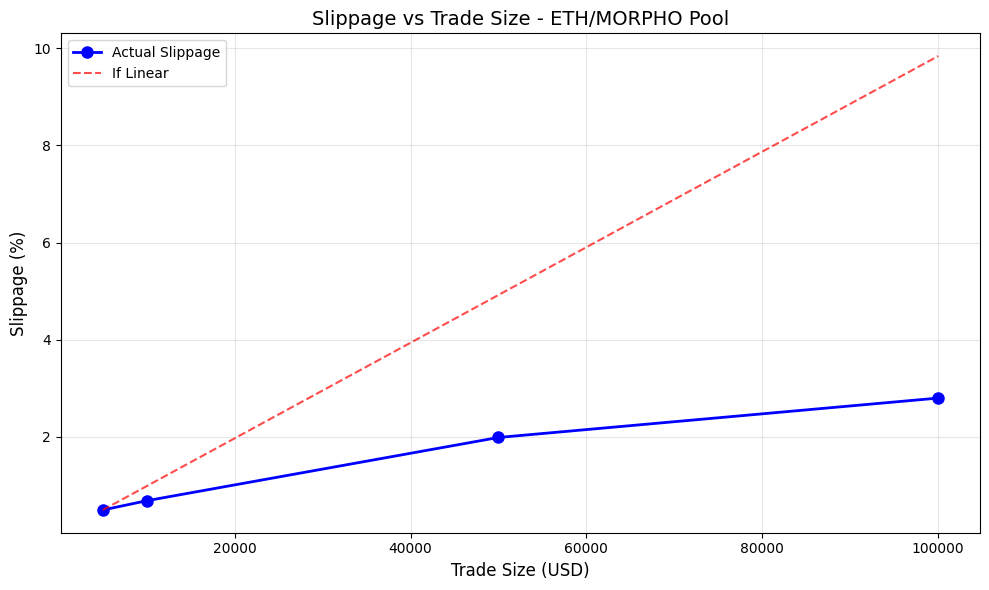

In [20]:
usd_amounts = [r["usd_amount"] for r in results]
slippages = [r["slippage_percentage"] for r in results]

fig, ax = plt.subplots(figsize=(10, 6))

# Actual slippage
ax.plot(usd_amounts, slippages, 'bo-', linewidth=2, markersize=8, label='Actual Slippage')

# Linear reference line (what it would look like if slippage were linear)
linear_slippage = [slippages[0] * (usd / usd_amounts[0]) for usd in usd_amounts]
ax.plot(usd_amounts, linear_slippage, 'r--', linewidth=1.5, alpha=0.7, label='If Linear')

ax.set_xlabel('Trade Size (USD)', fontsize=12)
ax.set_ylabel('Slippage (%)', fontsize=12)
ax.set_title('Slippage vs Trade Size - ETH/MORPHO Pool', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("plots/slippage_vs_trade_size.png", bbox_inches="tight")
plt.show()

## Why Slippage is Non-Linear

We assume that $x$ is the input token (ETH) and $y$ is the output token (MORPHO).

**The spot price is:**

$$
P_{\text{spot}} = \frac{y}{x}.
$$

Starting from the constant-product invariant ($xy = k$):

$$
x y = (x + \Delta x)(y - \Delta y),
$$

expand the right side:

$$
xy = xy + \Delta x \cdot y - x \cdot \Delta y - \Delta x \cdot \Delta y,
$$

subtract $xy$ from both sides:

$$
0 = \Delta x \cdot y - x \cdot \Delta y - \Delta x \cdot \Delta y,
$$

rearrange:

$$
x \cdot \Delta y + \Delta x \cdot \Delta y = \Delta x \cdot y,
$$

factor out $\Delta y$:

$$
(x + \Delta x) \Delta y = \Delta x \cdot y,
$$

and solve for $\Delta y$:

$$
\Delta y = \frac{\Delta x \cdot y}{x + \Delta x}.
$$

Thus the execution price is:

$$
P_{\text{exec}}
= \frac{\Delta y}{\Delta x}
= \frac{y}{x + \Delta x}.
$$

**Slippage derivation**

Slippage is defined as:

$$
S = \frac{\lvert P_{\text{spot}} - P_{\text{exec}} \rvert}{P_{\text{spot}}}.
$$

Insert the two expressions: $P_{\text{spot}} = \dfrac{y}{x}$ and $P_{\text{exec}} = \dfrac{y}{x + \Delta x}$

Compute the numerator:

$$
P_{\text{spot}} - P_{\text{exec}}
= \frac{y}{x} - \frac{y}{x + \Delta x}
= y\left(\frac{1}{x} - \frac{1}{x + \Delta x}\right)
= y\left(\frac{x + \Delta x - x}{x(x + \Delta x)}\right)
= y\left(\frac{\Delta x}{x(x + \Delta x)}\right).
$$

Divide by $P_{\text{spot}} = \frac{y}{x}$:

$$
S
= \frac{y\left( \dfrac{\Delta x}{x(x + \Delta x)} \right)}{\dfrac{y}{x}}
= \frac{\Delta x}{x + \Delta x}.
$$

So slippage simplifies to the very compact expression:

$$
S = \frac{\Delta x}{x + \Delta x}.
$$

**Conclusion:** This is a hyperbola, which explains the sub-linear (diminishing) slippage growth. Note that this assumes the constant product relationship within a single LP range.

## 1.2 Total Value Locked (TVL)

Pull current TVL in both tokens from the V4 singleton using two methods. Seems like in V4 there is no way to get the $P_a$ and $P_b$ values. Hence we use one approximation to get the data from teh V4 singelton and one exact methods using the GraphQL API.

### Method 1: On-chain Tick Iteration (Approximation)

Iterate through initialized ticks and calculate token amounts using concentrated liquidity math:

$$
(\text{amount}_0, \text{amount}_1) =
\begin{cases}
\left( L \left( \frac{1}{\sqrt{P_a}} - \frac{1}{\sqrt{P_b}} \right), 0 \right) & \text{if } \sqrt{P} \le \sqrt{P_a} \\[10pt]
\left( 0, L(\sqrt{P_b} - \sqrt{P_a}) \right) & \text{if } \sqrt{P} \ge \sqrt{P_b} \\[10pt]
\left( L \left( \frac{1}{\sqrt{P}} - \frac{1}{\sqrt{P_b}} \right), L(\sqrt{P} - \sqrt{P_a}) \right) & \text{otherwise}
\end{cases}
$$

### Method 2: GraphQL API (Exact)

Query the Uniswap interface gateway for pool-specific TVL data.

In [21]:
# Create StateView contract instance using the extended ABI
stateview = w3.eth.contract(address=STATE_VIEW_CS, abi=STATEVIEW_ABI_EXTENDED)

In [22]:
# Get current pool state using helper functions
sqrt_price_x96, current_tick, protocol_fee, lp_fee = get_slot0(stateview, POOL_ID_BYTES)
current_liquidity = get_pool_liquidity(stateview, POOL_ID_BYTES)

# Use Decimal-based function for precise price calculation
spot_price = sqrt_price_x96_to_price(sqrt_price_x96)

print(f"Current tick: {current_tick}")
print(f"Spot Price: {float(spot_price):,.6f}")
print(f"Current liquidity (L): {current_liquidity:,}")

Current tick: 78410
Spot Price: 2,541.845553
Current liquidity (L): 42,423,766,391,108,996,091,256


In [23]:
# Find all initialized ticks using the imported function from liquidity_distribution
print("Scanning for initialized ticks...")
initialized_ticks = find_initialized_ticks(stateview, POOL_ID_BYTES, TICK_SPACING, search_range=100)

print(f"Found {len(initialized_ticks)} initialized ticks")
if initialized_ticks:
    print(f"Tick range: {min(initialized_ticks)} to {max(initialized_ticks)}")

Scanning for initialized ticks...
Found 19 initialized ticks
Tick range: -887220 to 887220


In [24]:
# Method 1: On-chain TVL Calculation (tick iteration)
print("Calculating TVL from on-chain tick data...\n")

amount0_raw, amount1_raw = calculate_tvl_from_ticks(stateview, POOL_ID_BYTES, TICK_SPACING, search_range=100)

# Convert from raw units (both ETH and MORPHO have 18 decimals)
onchain_eth = amount0_raw / 10**18
onchain_morpho = amount1_raw / 10**18

# Calculate USD values
onchain_eth_usd = onchain_eth * eth_price_usd
onchain_morpho_usd = onchain_morpho * morpho_price_usd
onchain_total_usd = onchain_eth_usd + onchain_morpho_usd

print("--- Method 1: On-Chain Results ---")
print("\nToken Amounts:")
print(f"  ETH (token0):    {onchain_eth:,.6f} ETH")
print(f"  MORPHO (token1): {onchain_morpho:,.6f} MORPHO")
print("\nUSD Values:")
print(f"  ETH value:       ${onchain_eth_usd:,.2f}")
print(f"  MORPHO value:    ${onchain_morpho_usd:,.2f}")
print(f"  Total TVL:       ${onchain_total_usd:,.2f}")

Calculating TVL from on-chain tick data...



--- Method 1: On-Chain Results ---

Token Amounts:
  ETH (token0):    308.069346 ETH
  MORPHO (token1): 1,641,742.412154 MORPHO

USD Values:
  ETH value:       $945,055.09
  MORPHO value:    $1,986,508.32
  Total TVL:       $2,931,563.41


In [25]:
# Method 2: GraphQL TVL Calculation (Uniswap API)
print("Fetching TVL from Uniswap GraphQL API...\n")

try:
    graphql_data = fetch_pool_tvl_graphql(POOL_ID)  # POOL_ID is hex string
    
    print("--- Method 2: GraphQL Results ---")
    
    if graphql_data:
        # Token amounts
        graphql_eth = graphql_data.get("token0Supply", 0) or 0
        graphql_morpho = graphql_data.get("token1Supply", 0) or 0
        
        print("\nToken Amounts:")
        print(f"  ETH (token0):    {graphql_eth:,.6f} ETH")
        print(f"  MORPHO (token1): {graphql_morpho:,.6f} MORPHO")
        
        # USD values
        graphql_eth_usd = graphql_eth * eth_price_usd
        graphql_morpho_usd = graphql_morpho * morpho_price_usd
        
        # Total TVL from graph
        total_liq = graphql_data.get("totalLiquidity", {}) or {}
        graphql_total_usd = float(total_liq.get("value", 0) or 0)
        
        print("\nUSD Values:")
        print(f"  ETH value:       ${graphql_eth_usd:,.2f}")
        print(f"  MORPHO value:    ${graphql_morpho_usd:,.2f}")
        print(f"  Total TVL:       ${graphql_total_usd:,.2f}")

except Exception as e:
    print(f"GraphQL query failed: {e}")

Fetching TVL from Uniswap GraphQL API...

--- Method 2: GraphQL Results ---

Token Amounts:
  ETH (token0):    353.662742 ETH
  MORPHO (token1): 1,735,122.572431 MORPHO

USD Values:
  ETH value:       $1,084,920.58
  MORPHO value:    $2,099,498.31
  Total TVL:       $3,182,093.34


## 1.3 Theoretical Slippage vs TVL Relationship

Testing the hypothesis: does the theoretical slippage formula $S = \frac{\Delta x}{x + \Delta x}$ match the actual slippage from the Quoter?

USD Amount   Actual %     Theoretical %
------------------------------------------------
$5,000       0.4921       0.1569      
$10,000      0.6835       0.3133      
$50,000      1.9863       1.5470      
$100,000     2.7977       3.0468      


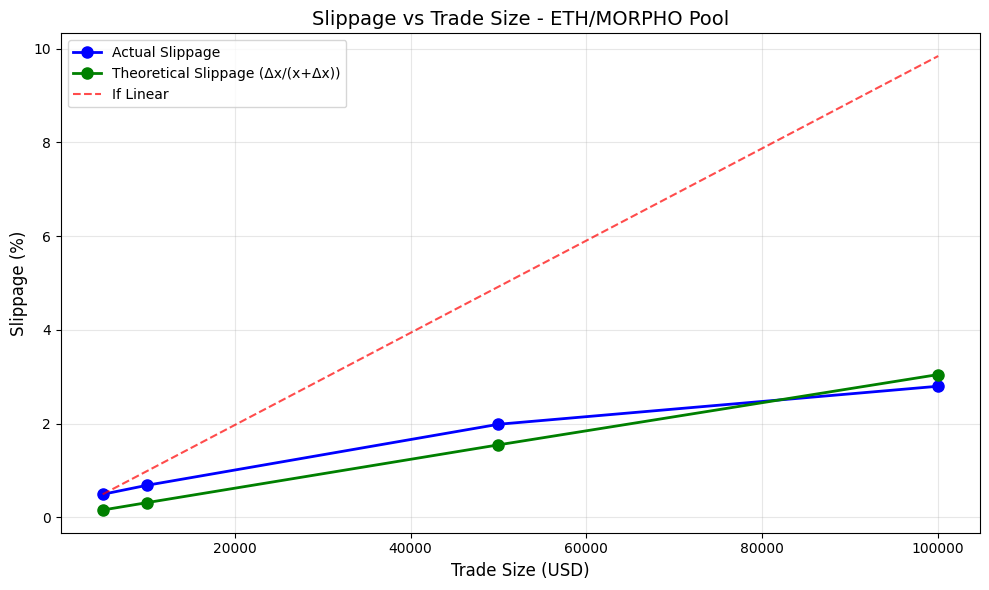

In [26]:
usd_amounts = [r["usd_amount"] for r in results]
slippages = [r["slippage_percentage"] for r in results]

# Theoretical slippage using GraphQL TVL (in USD)
theoretical_slippage = [d / (d + graphql_total_usd) * 100 for d in usd_amounts]

fig, ax = plt.subplots(figsize=(10, 6))

# Actual slippage
ax.plot(usd_amounts, slippages, 'bo-', linewidth=2, markersize=8, label='Actual Slippage')

# Theoretical slippage (constant product formula)
ax.plot(usd_amounts, theoretical_slippage, 'go-', linewidth=2, markersize=8, label='Theoretical Slippage (Δx/(x+Δx))')

# Linear reference line (what it would look like if slippage were linear)
linear_slippage = [slippages[0] * (usd / usd_amounts[0]) for usd in usd_amounts]
ax.plot(usd_amounts, linear_slippage, 'r--', linewidth=1.5, alpha=0.7, label='If Linear')

ax.set_xlabel('Trade Size (USD)', fontsize=12)
ax.set_ylabel('Slippage (%)', fontsize=12)
ax.set_title('Slippage vs Trade Size - ETH/MORPHO Pool', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Print comparison table
print(f"{'USD Amount':<12} {'Actual %':<12} {'Theoretical %':<12}")
print("-" * 48)
for usd, actual, theo in zip(usd_amounts, slippages, theoretical_slippage):
    print(f"${usd:<11,} {actual:<12.4f} {theo:<12.4f}")

plt.tight_layout()
plt.savefig("plots/slippage_theoretical_vs_actual.png", bbox_inches="tight")
plt.show()

## Observations

The theoretical and actual slippage curves are both hyperbolic but don't perfectly align. This discrepancy is expected because:

- The theoretical formula assumes **V2 constant-product** math (single global liquidity)
- The actual pool uses **V3/V4 concentrated liquidity** (liquidity varies across tick ranges)

In concentrated liquidity, slippage depends on how liquidity is distributed across ticks, not just total TVL.